In [77]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

#### 95th percentile  treshold

In [78]:
import os
import pandas as pd

def process_commit_history(csv_file, current_time="2024-1-1"):
    df = pd.read_csv(csv_file)
    
 
    df = df.dropna(subset=['date'])
    
 
    if df.empty:
        return None
    
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    df['timestamp'] = df['date'].astype('datetime64[s]')  
    df = df.sort_values(by=['timestamp'], ascending=True)
    
    df['interval'] = df['timestamp'].diff().dt.total_seconds()
    
    k=20
     # Focus on the most recent k commits
    if len(df) > k:
        df = df.iloc[-k:]
        
        
    mean_interval = df['interval'].mean()
    sd_interval = df['interval'].std()
    N = len(df)
    alpha=.5
    #2/(N+1)
    
    # Calculate EMA of commit intervals using the provided alpha
    df['ema'] = df['interval'].ewm(alpha=alpha, adjust=False).mean()
    
    Z = df['interval'].max()
    percentile_95 = df['interval'].dropna().quantile(0.95)
    EMA_last = df['ema'].iloc[-1]  # EMA of the last commit interval
    T = pd.to_datetime(current_time)
    
    # Time since last commit to T
    T_X_n = (T - df['timestamp'].iloc[-1]).total_seconds()
    time_since_last_commit_days = T_X_n / (60 * 60 * 24)
    
    
    classification = "unknown"
    if T_X_n  > Z*2:
        # Reclassify as "alive" if within a certain SD from the mean
        if abs(T_X_n - mean_interval) < sd_interval:
            classification = "alive"
        else:
            classification = "dead"
    elif T_X_n < percentile_95:
        classification = "alive"
    
    repo_name = os.path.basename(csv_file).split('.')[0]
    return {
        'Repo': repo_name,
        'Z': Z,
        'EMA_last': EMA_last,
        'T_X_n': T_X_n,
        'Percentile_95': percentile_95,
        'Classification': classification,
        'TimeSinceLastCommit': time_since_last_commit_days
}


folder_path = '/Users/ethan/Documents/Data science/MQP/main_repo_df/Data/CommitData'  
results_list = []  

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        csv_path = os.path.join(folder_path, file_name)
        result = process_commit_history(csv_path)
        if result:  # Only add if result is not None
            results_list.append(result)

 
results_df = pd.DataFrame(results_list)

C:\Users\ethan\AppData\Local\Temp\ipykernel_18604\2299741336.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
C:\Users\ethan\AppData\Local\Temp\ipykernel_18604\2299741336.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)


In [79]:
results_df.head(1)

,Repo,Z,EMA_last,T_X_n,Percentile_95,Classification,TimeSinceLastCommit
0,C_0voice_campus_recruitmen_questions,1468386.0,729766.006777,74169553.0,1145441.1,dead,858.4439


In [80]:
results_df

,Repo,Z,EMA_last,T_X_n,Percentile_95,Classification,TimeSinceLastCommit
0,C_0voice_campus_recruitmen_questions,1468386.0,7.297660e+05,74169553.0,1145441.10,dead,858.443900
1,C_0xAX_linux-insides,9252379.0,7.014816e+06,10496672.0,7771088.65,unknown,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,7.861154e+06,38212334.0,19001707.50,unknown,442.272384
3,C_2d-inc_developer_quest,6848421.0,9.846549e+05,127440288.0,6666438.05,dead,1475.003333
4,C_350306878_Kuai-Shua-Questions,64032394.0,1.969076e+07,9908926.0,47606254.65,alive,114.686644
...,...,...,...,...,...,...,...
1746,C_zpao_qrcode,5850573.0,1.215303e+06,696362.0,4869117.55,alive,8.059745
1747,C_zqzess_rule_for_quantumultX,604860.0,4.790499e+03,577893.0,604834.35,alive,6.688576
1748,C_zs9024_quick_psd2ugui,58344447.0,1.101626e+05,57677255.0,15326063.45,unknown,667.560822
1749,C_zxing_zxing,3024047.0,1.665075e+05,2371857.0,734788.30,unknown,27.452049


In [81]:
results_df['TimeSinceLastCommit'].describe()

count    1751.000000
mean      731.497174
std       932.519463
min         1.510486
25%        32.896117
50%       283.446366
75%      1181.003287
max      5020.900463
Name: TimeSinceLastCommit, dtype: float64

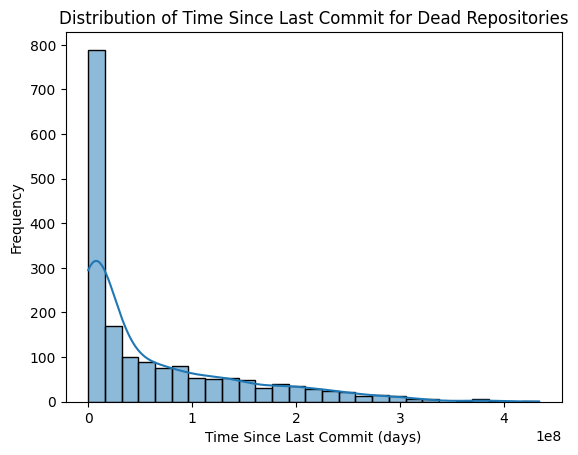

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

 
sns.histplot(results_df['T_X_n'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


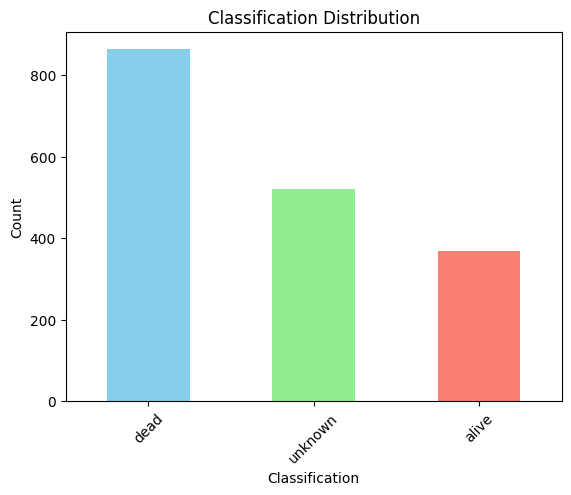

In [83]:
import matplotlib.pyplot as plt

classification_counts = results_df['Classification'].value_counts()
classification_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Classification Distribution')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Dead repos 

In [84]:
dead_repos_df = results_df[results_df['Classification'] == 'dead']
dead_repos_df.head(10)

,Repo,Z,EMA_last,T_X_n,Percentile_95,Classification,TimeSinceLastCommit
0,C_0voice_campus_recruitmen_questions,1468386.0,7.297660e+05,74169553.0,1145441.10,dead,858.443900
3,C_2d-inc_developer_quest,6848421.0,9.846549e+05,127440288.0,6666438.05,dead,1475.003333
7,C_9magnets_iOS-Developer-and-Designer-Intervie...,52066745.0,1.387880e+07,207744379.0,17438028.05,dead,2404.448831
9,C_AbhishekChourasiya_Leetcode-Questions,356.0,3.560000e+02,128771801.0,356.00,dead,1490.414363
10,C_abuanwar072_Quiz-App-Flutter,28052746.0,1.592659e+07,57097704.0,22938332.75,dead,660.853056
11,C_academind_node-restful-api-tutorial,126883.0,6.657250e+04,192108057.0,120851.95,dead,2223.472882
15,C_adamisntdead_QuSimPy,38543496.0,4.242416e+06,172234206.0,12163727.85,dead,1993.451458
17,C_addyosmani_backbone-fundamentals,36341992.0,6.567011e+05,191057648.0,12610901.75,dead,2211.315370
18,C_adiew-code_QQ,772850.0,1.947692e+05,249430357.0,271444.75,dead,2886.925428
19,C_Advanced-Frontend_Daily-Interview-Question,13667537.0,3.845719e+06,99183181.0,9445272.45,dead,1147.953484


In [85]:
sorted_dead_repos_df = dead_repos_df.sort_values(by='TimeSinceLastCommit')
sorted_dead_repos_df

,Repo,Z,EMA_last,T_X_n,Percentile_95,Classification,TimeSinceLastCommit
296,C_deezertidal_QuantumultX-Rewrite,10529.0,6.777729e+03,328631.0,10495.75,dead,3.803600
701,C_justjake_quickjs-emscripten,11138.0,5.733338e+03,379766.0,6606.50,dead,4.395440
1440,C_singerdmx_flutter-quill,183188.0,9.510815e+02,390365.0,156744.75,dead,4.518113
1236,C_quarkusio_quarkusio,172993.0,1.478373e+05,425682.0,172766.90,dead,4.926875
1520,C_TanStack_query,161801.0,6.663387e+03,464829.0,149349.35,dead,5.379965
...,...,...,...,...,...,...,...
1137,C_punkave_phpQuery,364.0,3.640000e+02,382092634.0,364.00,dead,4422.368449
875,C_lorensiuswlt_NewQuickAction3D,7033736.0,6.731289e+05,385339174.0,5798779.80,dead,4459.944144
570,C_huacnlee_quora,820332.0,1.438466e+05,385840367.0,774179.10,dead,4465.744988
1112,C_placemarker_jQuery-MD5,7546712.0,2.053583e+06,396091502.0,5972567.20,dead,4584.392384


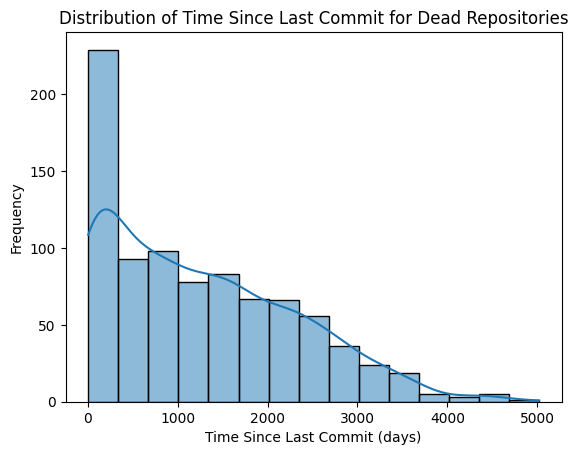

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

 
sns.histplot(dead_repos_df['TimeSinceLastCommit'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


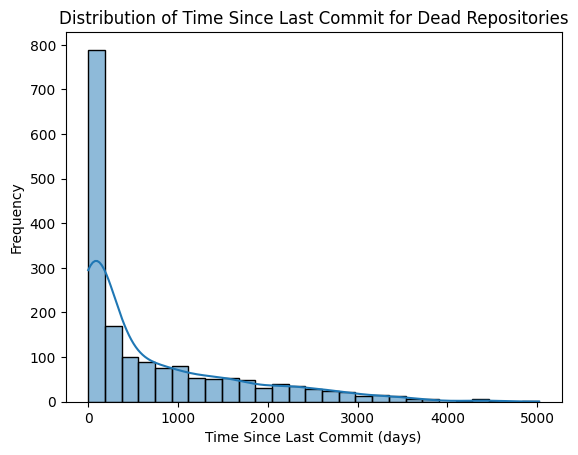

In [87]:
 
sns.histplot(results_df['TimeSinceLastCommit'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

#### Alive repos 

In [88]:
alive_repos_df = results_df[results_df['Classification'] == 'alive']
alive_repos_df.head(10)

,Repo,Z,EMA_last,T_X_n,Percentile_95,Classification,TimeSinceLastCommit
4,C_350306878_Kuai-Shua-Questions,64032394.0,1.969076e+07,9908926.0,47606254.65,alive,114.686644
5,C_78778443_QingScan,14194587.0,8.502524e+06,3143181.0,7624487.70,alive,36.379410
6,C_89996462_Quantumult-X,596400.0,1.435513e+05,396044.0,523224.35,alive,4.583843
8,C_aamirafridi_jQuery,64920542.0,2.973950e+07,31156632.0,58954010.95,alive,360.609167
12,C_acmerobotics_road-runner-quickstart,1309024.0,9.512197e+04,609549.0,834435.35,alive,7.054965
27,C_airbnb_lottie-android,4840517.0,1.194863e+06,1404002.0,2433044.10,alive,16.250023
28,C_airbnb_lottie-ios,1547513.0,2.579900e+05,890655.0,1459216.20,alive,10.308507
29,C_airbus-seclab_qemu_blog,24165616.0,9.476286e+06,5057537.0,21513684.25,alive,58.536308
30,C_airyland_vux,25317099.0,6.504802e+05,16384867.0,16829143.50,alive,189.639664
31,C_aizvorski_video-quality,118991936.0,6.486598e+07,4859445.0,84908819.60,alive,56.243576


In [89]:
sorted_alive_repos_df = alive_repos_df.sort_values(by='TimeSinceLastCommit', ascending=False)
sorted_alive_repos_df

,Repo,Z,EMA_last,T_X_n,Percentile_95,Classification,TimeSinceLastCommit
196,C_chentao0707_QrCodeScan,193643383.0,4.908430e+07,96135592.0,1.096517e+08,alive,1112.680463
1593,C_udacity_ud843-QuakeReport,182957271.0,1.829573e+08,59138959.0,1.829573e+08,alive,684.478692
1511,C_ta-data-lis_lab-mysql-first-queries,82269216.0,1.028398e+07,55584758.0,6.170421e+07,alive,643.342106
1579,C_tvvocold_How-To-Ask-Questions-The-Smart-Way,154258970.0,4.307206e+07,54412381.0,1.367203e+08,alive,629.772928
1564,C_tomnomnom_qsreplace,82187479.0,2.189544e+07,48051981.0,7.026392e+07,alive,556.157187
...,...,...,...,...,...,...,...
1189,C_qiskit-community_qiskit-metal,4044268.0,5.998982e+05,263663.0,3.823814e+06,alive,3.051655
195,C_chengyangkj_Ros_Qt5_Gui_App,929405.0,1.636804e+03,219493.0,7.754053e+05,alive,2.540428
1176,C_qdrant_quaterion,23259267.0,1.172760e+07,212763.0,4.701358e+06,alive,2.462535
1161,C_qbcore-framework_qb-phone,6978492.0,1.975468e+06,191893.0,6.533335e+06,alive,2.220984


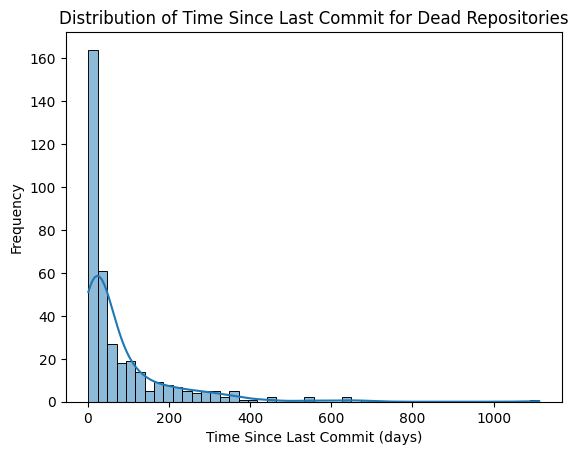

In [90]:
sns.histplot(alive_repos_df['TimeSinceLastCommit'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

In [91]:
dead_repos_df

,Repo,Z,EMA_last,T_X_n,Percentile_95,Classification,TimeSinceLastCommit
0,C_0voice_campus_recruitmen_questions,1468386.0,7.297660e+05,74169553.0,1145441.10,dead,858.443900
3,C_2d-inc_developer_quest,6848421.0,9.846549e+05,127440288.0,6666438.05,dead,1475.003333
7,C_9magnets_iOS-Developer-and-Designer-Intervie...,52066745.0,1.387880e+07,207744379.0,17438028.05,dead,2404.448831
9,C_AbhishekChourasiya_Leetcode-Questions,356.0,3.560000e+02,128771801.0,356.00,dead,1490.414363
10,C_abuanwar072_Quiz-App-Flutter,28052746.0,1.592659e+07,57097704.0,22938332.75,dead,660.853056
...,...,...,...,...,...,...,...
1736,C_zeruniverse_QQRobot,35938314.0,1.515086e+06,207781430.0,9039402.20,dead,2404.877662
1740,C_zhihao-chen_QASystemOnMedicalGraph,5260996.0,1.536061e+06,145393563.0,3551732.60,dead,1682.795868
1742,C_zhuxuedefeng_AiQiangGUO,8192130.0,2.248819e+06,82317576.0,4929800.40,dead,952.749722
1743,C_ziadoz_awesome-php,6268706.0,1.224137e+06,45455853.0,4786454.25,dead,526.109410


In [92]:
unknown = results_df[results_df['Classification'] == 'unknown']

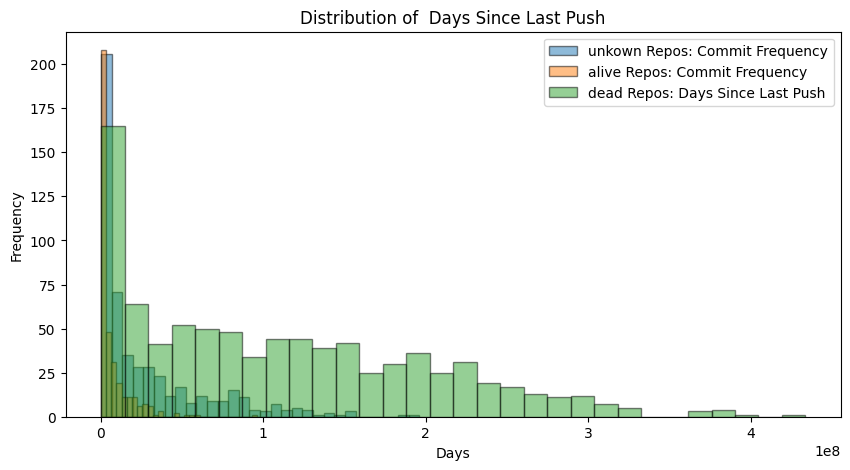

In [93]:
plt.figure(figsize=(10, 5))

plt.hist(unknown['T_X_n'], bins=30, alpha=0.5, label='unkown Repos: Commit Frequency', edgecolor='black')

plt.hist(alive_repos_df['T_X_n'], bins=30, alpha=0.5, label='alive Repos: Commit Frequency', edgecolor='black')

# Plotting 'daysSinceLastPush' for alive repositories
plt.hist(dead_repos_df['T_X_n'], bins=30, alpha=0.5, label='dead Repos: Days Since Last Push', edgecolor='black')

 
plt.title('Distribution of  Days Since Last Push')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.legend()
plt.show()



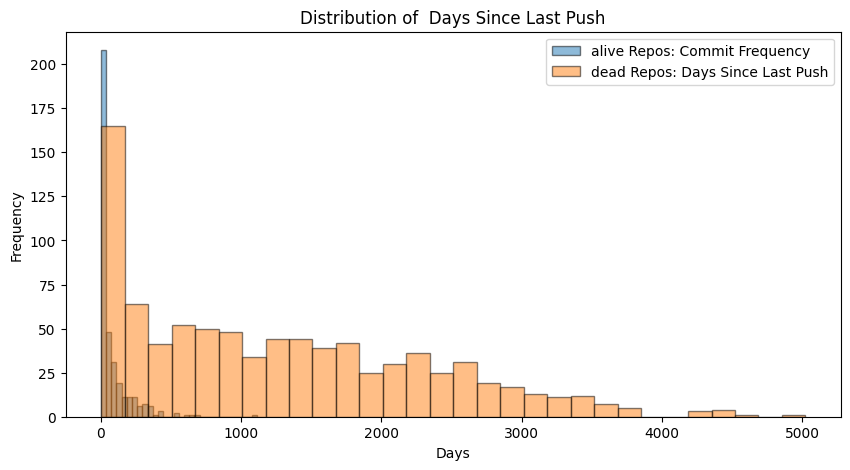

In [94]:
plt.figure(figsize=(10, 5))

# Plotting 'commitFrequency' for dead repositories
plt.hist(alive_repos_df['TimeSinceLastCommit'], bins=30, alpha=0.5, label='alive Repos: Commit Frequency', edgecolor='black')

# Plotting 'daysSinceLastPush' for alive repositories
plt.hist(dead_repos_df['TimeSinceLastCommit'], bins=30, alpha=0.5, label='dead Repos: Days Since Last Push', edgecolor='black')

plt.title('Distribution of  Days Since Last Push')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.legend()
plt.show()



#### merge datasets

In [95]:
graph_data=pd.read_csv('../data/ml_data/graph_data_stats.csv', sep=",",index_col=0)
graph_data.drop('index', axis=1, inplace=True)
graph_data.head(1)

,owner,repo,stars,dateCreated,datePushed,numCommits,openIssues,closedIssues,totalIssues,totalAdditions,...,Fun Rt,nloc Rt,Halstead Volume,Maintainability Index,open_close_ratio,daysSinceLastPush,repoAgeDays,commitFrequency,closedIssueRatio,openIssueRatio
0,facebook,react,216019,2013-05-24 16:15:54,2023-12-08 00:51:20,16117,1557,25219,26776,2734078.0,...,0.01,0.06,1831.576017,57.03145,0.061737,0,3849,0.238816,0.941816,0.058147
